In [1]:
import pandas as pd          
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

In [2]:
df = pd.concat(map(pd.read_csv, ['tennis_atp/atp_matches_2018.csv','tennis_atp/atp_matches_2019.csv', 'tennis_atp/atp_matches_2020.csv','tennis_atp/atp_matches_2021.csv','tennis_atp/atp_matches_2022.csv','tennis_atp/atp_matches_2023.csv','tennis_atp/atp_matches_2024.csv']))

In [3]:
# Remove identifying data
# Find a way to include tourney_level and score
df = df.drop(columns=['winner_id', 'winner_name', 'winner_ioc', 
                      'loser_id', 'loser_name', 'loser_ioc', 
                      'tourney_id', 'tourney_name', 'tourney_level', 
                      'tourney_date', 'match_num', 'winner_seed', 
                      'winner_entry', 'loser_seed', 'loser_entry','score', 'draw_size', 'best_of', 'round', "w_SvGms", "l_SvGms", "w_bpSaved", "l_bpSaved", "w_bpFaced", "l_bpFaced",'minutes'])
# "w_SvGms", "l_SvGms", "w_bpSaved", "l_bpSaved", "w_bpFaced", "l_bpFaced","minutes"

In [4]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates no action needed
print(df.duplicated().sum())

# Drop any rows with nulls in them
df = df.dropna()

# Check total number of rows, should be over 15k
row_count = len(df)
print(row_count)

surface                53
winner_hand             0
winner_ht              79
winner_age              3
loser_hand              1
loser_ht              227
loser_age               3
w_ace                 694
w_df                  694
w_svpt                694
w_1stIn               694
w_1stWon              694
w_2ndWon              694
l_ace                 694
l_df                  694
l_svpt                694
l_1stIn               694
l_1stWon              694
l_2ndWon              694
winner_rank            79
winner_rank_points     79
loser_rank            222
loser_rank_points     222
dtype: int64
2
17946


## Convert Categorical Variables to Numerical

In [5]:
winner_encoder = LabelEncoder()
loser_encoder = LabelEncoder()
surface_encoder = LabelEncoder()
round_encoder = LabelEncoder()


df['winner_hand'] = winner_encoder.fit_transform(df['winner_hand'])
df['loser_hand'] = loser_encoder.fit_transform(df['loser_hand'])
df['surface'] = surface_encoder.fit_transform(df['surface'])
# df['round'] = round_encoder.fit_transform(df['round'])

In [6]:
# Rename values to not be associated with winner.
df = df.rename(columns={
    'winner_age': 'p1_age',
    'winner_ht': 'p1_ht',
    'winner_hand': 'p1_hand',
    'winner_rank': 'p1_rank',
    'winner_rank_points': 'p1_rank_points',
    'loser_age': 'p2_age',
    'loser_ht': 'p2_ht',
    'loser_hand': 'p2_hand',
    'loser_rank': 'p2_rank',
    'loser_rank_points': 'p2_rank_points',
    
    'w_ace': 'p1_ace',
    'w_df': 'p1_df',
    'w_svpt': 'p1_svpt',
    'w_1stIn': 'p1_1stIn',
    'w_1stWon': 'p1_1stWon',
    'w_2ndWon': 'p1_2ndWon',

    'l_ace': 'p2_ace',
    'l_df': 'p2_df',
    'l_svpt': 'p2_svpt',
    'l_1stIn': 'p2_1stIn',
    'l_1stWon': 'p2_1stWon',
    'l_2ndWon': 'p2_2ndWon',
})

swap_mask = np.random.rand(len(df)) > 0.5

swap_cols = [
    'age', 'ht', 'hand', 'rank', 'rank_points',
    'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon'
]

for col in swap_cols:
    temp = df.loc[swap_mask, f'p1_{col}'].copy()
    df.loc[swap_mask, f'p1_{col}'] = df.loc[swap_mask, f'p2_{col}']
    df.loc[swap_mask, f'p2_{col}'] = temp

df['winner'] = np.where(swap_mask, 1, 0)

print(df['winner'].value_counts())

winner
1    9044
0    8902
Name: count, dtype: int64


In [7]:
# Display the first and last few rows of the dataset.
display(df.head())
display(df.tail())

# Display the info of the dataset.
display(df.info())

# Display summary statistics of the dataset.
display(df.describe())

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
0,2,1,188.0,30.6,1,185.0,25.6,10.0,3.0,80.0,...,2.0,82.0,49.0,39.0,20.0,52.0,909.0,47.0,1010.0,1
1,2,1,183.0,23.7,1,188.0,21.2,3.0,5.0,62.0,...,3.0,58.0,32.0,25.0,14.0,94.0,593.0,54.0,890.0,1
2,2,1,175.0,25.6,1,185.0,31.3,8.0,6.0,120.0,...,0.0,94.0,66.0,48.0,12.0,30.0,1391.0,63.0,809.0,1
3,2,1,188.0,28.0,1,183.0,18.8,6.0,2.0,80.0,...,3.0,66.0,37.0,32.0,17.0,44.0,1055.0,208.0,245.0,1
4,2,0,193.0,27.2,1,188.0,19.9,4.0,0.0,45.0,...,4.0,55.0,38.0,32.0,11.0,68.0,755.0,175.0,299.0,1


,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
3064,2,1,175.0,25.0,1,183.0,28.2,1.0,2.0,52.0,...,1.0,50.0,35.0,19.0,5.0,569.0,64.0,819.0,24.0,0
3066,2,1,188.0,28.8,1,178.0,31.0,3.0,2.0,49.0,...,2.0,56.0,35.0,30.0,11.0,900.0,18.0,279.0,205.0,1
3068,0,0,185.0,23.9,1,188.0,21.8,1.0,2.0,74.0,...,5.0,92.0,52.0,24.0,18.0,616.0,55.0,740.0,34.0,0
3070,0,1,175.0,34.2,0,185.0,23.9,2.0,1.0,50.0,...,1.0,82.0,66.0,33.0,6.0,136.0,489.0,616.0,55.0,0
3074,2,1,175.0,26.9,1,185.0,27.3,0.0,1.0,84.0,...,3.0,86.0,51.0,32.0,17.0,554.0,67.0,416.0,109.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 17946 entries, 0 to 3074
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   surface         17946 non-null  int64  
 1   p1_hand         17946 non-null  int64  
 2   p1_ht           17946 non-null  float64
 3   p1_age          17946 non-null  float64
 4   p2_hand         17946 non-null  int64  
 5   p2_ht           17946 non-null  float64
 6   p2_age          17946 non-null  float64
 7   p1_ace          17946 non-null  float64
 8   p1_df           17946 non-null  float64
 9   p1_svpt         17946 non-null  float64
 10  p1_1stIn        17946 non-null  float64
 11  p1_1stWon       17946 non-null  float64
 12  p1_2ndWon       17946 non-null  float64
 13  p2_ace          17946 non-null  float64
 14  p2_df           17946 non-null  float64
 15  p2_svpt         17946 non-null  float64
 16  p2_1stIn        17946 non-null  float64
 17  p2_1stWon       17946 non-null  float

None

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
count,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,...,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000
mean,1.285468,0.862532,187.191352,27.154001,0.860136,187.268361,27.107701,6.284409,2.935807,81.040343,...,2.930848,81.052881,50.475426,36.129778,15.511312,79.284743,1528.784687,79.341859,1544.668115,0.503956
std,0.901457,0.344350,7.099519,4.562400,0.346856,7.073493,4.580926,5.434810,2.426886,29.112597,...,2.460263,29.318817,19.307400,14.286088,6.891954,107.838781,1722.299256,107.802139,1745.546467,0.499998
min,0.000000,0.000000,15.000000,16.500000,0.000000,15.000000,16.400000,0.000000,0.000000,3.000000,...,0.000000,4.000000,3.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,1.000000,183.000000,23.600000,1.000000,183.000000,23.600000,2.000000,1.000000,59.000000,...,1.000000,59.000000,36.000000,26.000000,11.000000,25.000000,640.000000,25.000000,649.000000,0.000000
50%,2.000000,1.000000,188.000000,26.800000,1.000000,188.000000,26.700000,5.000000,2.000000,76.000000,...,2.000000,76.000000,47.000000,34.000000,15.000000,55.000000,948.000000,55.000000,954.000000,1.000000
75%,2.000000,1.000000,193.000000,30.300000,1.000000,193.000000,30.200000,9.000000,4.000000,98.000000,...,4.000000,97.000000,61.000000,44.000000,19.000000,95.000000,1635.750000,93.000000,1645.000000,1.000000
max,2.000000,1.000000,211.000000,42.500000,1.000000,211.000000,42.300000,64.000000,26.000000,278.000000,...,26.000000,291.000000,218.000000,171.000000,53.000000,1921.000000,12415.000000,2146.000000,12415.000000,1.000000


In [8]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates
print(df.duplicated().sum())

surface           0
p1_hand           0
p1_ht             0
p1_age            0
p2_hand           0
p2_ht             0
p2_age            0
p1_ace            0
p1_df             0
p1_svpt           0
p1_1stIn          0
p1_1stWon         0
p1_2ndWon         0
p2_ace            0
p2_df             0
p2_svpt           0
p2_1stIn          0
p2_1stWon         0
p2_2ndWon         0
p1_rank           0
p1_rank_points    0
p2_rank           0
p2_rank_points    0
winner            0
dtype: int64
0


## Drop Nulls

In [9]:
# Drop any rows with nulls in them
df = df.dropna()

# Check 
row_count = len(df)
print(row_count)

17946


## Scale Features

In [10]:
scaler = StandardScaler()
y = df['winner'].values

X = df.drop(columns=['winner'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

display(y)
display(X)

array([1, 1, 1, ..., 0, 0, 0])

array([[ 0.79266389,  0.39922077,  0.113905  , ..., -0.35986891,
        -0.30001965, -0.30631268],
       [ 0.79266389,  0.39922077, -0.59038769, ..., -0.54334969,
        -0.23508407, -0.37506097],
       [ 0.79266389,  0.39922077, -1.71725598, ..., -0.08000266,
        -0.15159545, -0.42146607],
       ...,
       [-1.42602849, -2.50487971, -0.30867061, ..., -0.85573151,
         6.12860336, -0.86546548],
       [-1.42602849,  0.39922077, -1.71725598, ..., -0.60373576,
         4.97831584, -0.85343453],
       [ 0.79266389,  0.39922077, -1.71725598, ..., -0.84876389,
         3.12301338, -0.82249779]])

## Split data into testing and training

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
display(y_train)

array([0, 1, 0, ..., 1, 1, 1])

### Reusable function for evaluation

In [12]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(y_pred_test, y_pred_train):
  print("=== Test Metrics ===")
  accuracy_test = accuracy_score(y_test, y_pred_test)
  print(f"Accuracy: {accuracy_test}")

  precision_test = precision_score(y_test, y_pred_test, average='binary')
  print(f"Precision: {precision_test}")

  recall_test = recall_score(y_test, y_pred_test, average='binary')
  print(f"Recall: {recall_test}")

  f1_test = f1_score(y_test, y_pred_test, average='binary')
  print(f"F1 Score: {f1_test}")

  print("\n=== Training Metrics ===")
  accuracy_train = accuracy_score(y_train, y_pred_train)
  print(f"Accuracy: {accuracy_train}")

  precision_train = precision_score(y_train, y_pred_train, average='binary')
  print(f"Precision: {precision_train}")

  recall_train = recall_score(y_train, y_pred_train, average='binary')
  print(f"Recall: {recall_train}")

  f1_train = f1_score(y_train, y_pred_train, average='binary')
  print(f"F1 Score: {f1_train}")

  # Show the shape of training data
  print("\nX_train shape:", X_train.shape)

  # Confusion matrix for test data
  cm = confusion_matrix(y_test, y_pred_test)

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Class 0', 'Class 1'],
              yticklabels=['Class 0', 'Class 1'])
  plt.title('Confusion Matrix (Test Data)')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

In [13]:
def iterative_feature_elimination(clf, X_train, y_train, X_test, y_test, feature_names=None, target_name='winner'):    
    baseline_f1 = f1_score(y_test, clf.predict(X_test))
    print(f"Baseline F1: {baseline_f1:.4f}")
    
    if feature_names is None:
        # Try to infer feature names from a DataFrame if not provided
        try:
            feature_names = X_train.columns.tolist()
        except AttributeError:
            feature_names = [f"f{i}" for i in range(X_train.shape[1])]
    
    current_X_train = X_train.copy()
    current_X_test = X_test.copy()
    features = feature_names.copy()
    removed_features = []

    while len(features) > 1:
        selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
        selector.fit(current_X_train, y_train)

        new_f1 = f1_score(y_test, selector.predict(current_X_test))
        dropped_idx = np.where(~selector.support_)[0][0]
        dropped_feat = features[dropped_idx]

        if new_f1 < baseline_f1:
            removed_features.append(dropped_feat)
            print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
            break

        removed_features.append(dropped_feat)
        print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

        features.pop(dropped_idx)
        current_X_train = current_X_train[:, selector.support_]
        current_X_test = current_X_test[:, selector.support_]

    print(f"\nTotal removed: {len(removed_features)} features")
    print("Features removed (in order):")
    for feat in removed_features:
        print(f" - {feat}")

    return removed_features, features, new_f1

## Neural Network

In [14]:
# Shallow model for binary classification
shallow_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')  # Single output node with sigmoid for binary classification
])

shallow_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

shallow_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

shallow_test_loss, shallow_test_acc = shallow_model.evaluate(X_test, y_test, verbose=0)

y_pred = (shallow_model.predict(X_test) > 0.5).astype(int).flatten()

shallow_test_precision = precision_score(y_test, y_pred)
shallow_test_recall = recall_score(y_test, y_pred)
shallow_test_f1 = f1_score(y_test, y_pred)

print(f'Shallow Network Test Accuracy: {shallow_test_acc:.4f}')
print(f'Precision: {shallow_test_precision:.4f}')
print(f'Recall: {shallow_test_recall:.4f}')
print(f'F1 Score: {shallow_test_f1:.4f}')

C:\Users\mathe\anaconda3\envs\machineLearning\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6810 - loss: 0.5872 - val_accuracy: 0.8364 - val_loss: 0.3980
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8474 - loss: 0.3598 - val_accuracy: 0.9049 - val_loss: 0.2651
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9135 - loss: 0.2425 - val_accuracy: 0.9401 - val_loss: 0.1879
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9371 - loss: 0.1830 - val_accuracy: 0.9478 - val_loss: 0.1536
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9408 - loss: 0.1604 - val_accuracy: 0.9519 - val_loss: 0.1379
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9461 - loss: 0.1424 - val_accuracy: 0.9506 - val_loss: 0.1343
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9439 - loss: 0.1398 - val_accuracy: 0.9530 - val_loss: 0.1252
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9456 - loss: 0.1381 - val_accuracy: 0.

In [15]:
# Deep model for binary classification
deep_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

deep_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

deep_model_loss, deep_model_acc = shallow_model.evaluate(X_test, y_test, verbose=0)

y_pred = (shallow_model.predict(X_test) > 0.5).astype(int).flatten()

deep_model_precision = precision_score(y_test, y_pred)
deep_model_recall = recall_score(y_test, y_pred)
deep_model_f1 = f1_score(y_test, y_pred)

print(f'Shallow Network Test Accuracy: {deep_model_acc:.4f}')
print(f'Precision: {deep_model_precision:.4f}')
print(f'Recall: {deep_model_recall:.4f}')
print(f'F1 Score: {deep_model_f1:.4f}')

# Evaluate on test data
deep_test_loss, deep_test_acc = deep_model.evaluate(X_test, y_test, verbose=0)
print(f'Deep Network Test Accuracy: {deep_test_acc:.4f}')

C:\Users\mathe\anaconda3\envs\machineLearning\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7548 - loss: 0.4916 - val_accuracy: 0.9241 - val_loss: 0.1827
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9274 - loss: 0.1765 - val_accuracy: 0.9405 - val_loss: 0.1439
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9357 - loss: 0.1479 - val_accuracy: 0.9474 - val_loss: 0.1387
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9441 - loss: 0.1361 - val_accuracy: 0.9446 - val_loss: 0.1473
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9471 - loss: 0.1324 - val_accuracy: 0.9405 - val_loss: 0.1349
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9481 - loss: 0.1237 - val_accuracy: 0.9485 - val_loss: 0.1317
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9488 - loss: 0.1294 - val_accuracy: 0.9537 - val_loss: 0.1260
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9565 - loss: 0.1084 - val_accuracy: 0.

## Logistic Regression

=== Test Metrics ===
Accuracy: 0.9518105849582172
Precision: 0.956858407079646
Recall: 0.947945205479452
F1 Score: 0.9523809523809523

=== Training Metrics ===
Accuracy: 0.9474784062412929
Precision: 0.9462929725251967
Recall: 0.9494389804682088
F1 Score: 0.9478633660627852

X_train shape: (14356, 23)


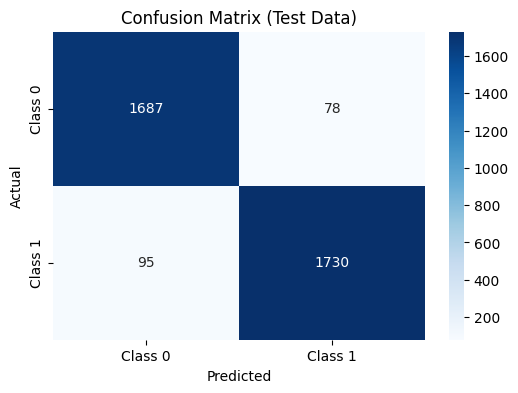

In [16]:
from sklearn.linear_model import LogisticRegression

# Train the model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9515320334261839
Precision: 0.9563294637921503
Recall: 0.947945205479452
F1 Score: 0.9521188772702256

=== Training Metrics ===
Accuracy: 0.9476873780997492
Precision: 0.9461920529801324
Recall: 0.9499930738329408
F1 Score: 0.9480887537153522

X_train shape: (14356, 23)


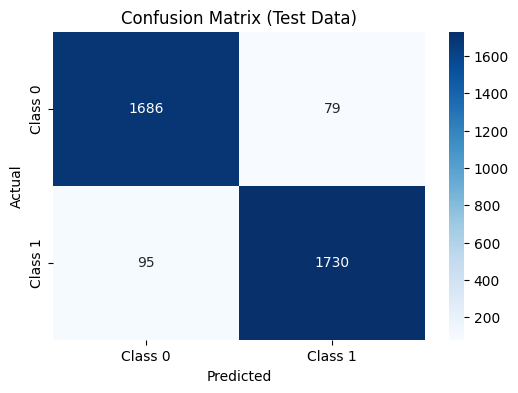

In [17]:
from sklearn.ensemble import BaggingClassifier
# Use logistic model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9272980501392758
Precision: 0.9334811529933481
Recall: 0.9227397260273973
F1 Score: 0.9280793607054285

=== Training Metrics ===
Accuracy: 0.9270688213987183
Precision: 0.9318499860061573
Recall: 0.922426928937526
F1 Score: 0.9271145144448312

X_train shape: (14356, 23)


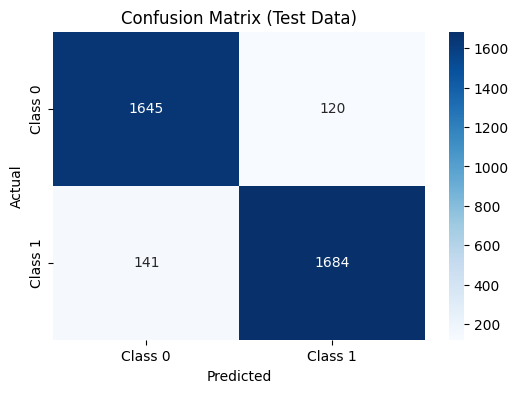

In [18]:
from sklearn.ensemble import AdaBoostClassifier
# Use logistic model 
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Method
running the RFE wrapper method recursively until the percision value begins decreasing from the elimination of Features within the dataset

In [19]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.9524
Removed 'p2_ace' → new F1 = 0.9524
Removed 'p2_rank' → new F1 = 0.9527
→ Stopping: dropping 'p1_ht' drops F1 from 0.9524 to 0.9521

Total removed: 3 features
Features removed (in order):
 - p2_ace
 - p2_rank
 - p1_ht


## DecisionTreeClassifier

=== Test Metrics ===
Accuracy: 0.6721448467966574
Precision: 0.7539184952978056
Recall: 0.5271232876712328
F1 Score: 0.6204450177362141

=== Training Metrics ===
Accuracy: 0.6646698244636389
Precision: 0.7397806580259222
Recall: 0.5139215957888904
F1 Score: 0.606506457413765

X_train shape: (14356, 23)


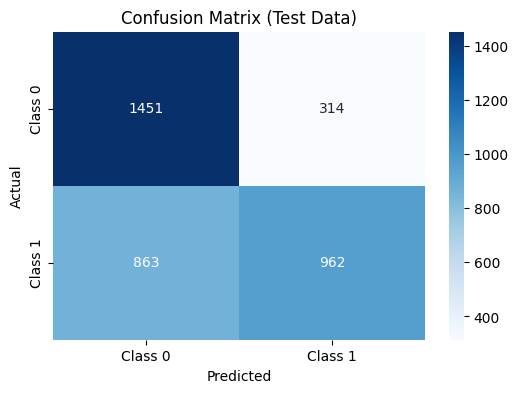

In [20]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.7181058495821727
Precision: 0.7683168316831683
Recall: 0.6378082191780822
F1 Score: 0.6970059880239521

=== Training Metrics ===
Accuracy: 0.7183755920869322
Precision: 0.7621327170683394
Recall: 0.6395622662418617
F1 Score: 0.6954884386533102

X_train shape: (14356, 23)


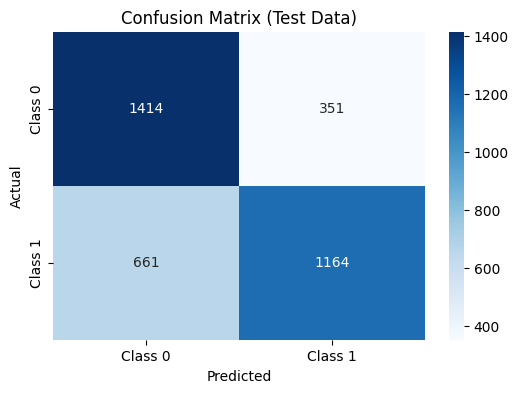

In [21]:
# Use decision tree model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9194986072423398
Precision: 0.9257206208425721
Recall: 0.915068493150685
F1 Score: 0.9203637365665472

=== Training Metrics ===
Accuracy: 0.9591111730286987
Precision: 0.9576317968534364
Recall: 0.961213464468763
F1 Score: 0.9594192879363982

X_train shape: (14356, 23)


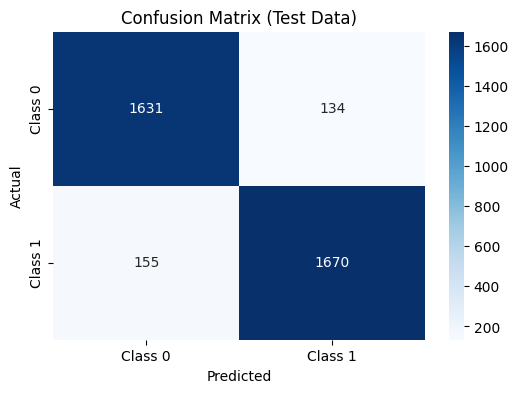

In [22]:
# Use decision tree model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Methods

In [23]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.6204
Removed 'surface' → new F1 = 0.6204
Removed 'p1_hand' → new F1 = 0.6204
Removed 'p1_ht' → new F1 = 0.6204
Removed 'p1_age' → new F1 = 0.6204
Removed 'p2_hand' → new F1 = 0.6204
Removed 'p2_ht' → new F1 = 0.6204
Removed 'p2_age' → new F1 = 0.6204
Removed 'p1_ace' → new F1 = 0.6204
Removed 'p1_df' → new F1 = 0.6204
Removed 'p1_1stIn' → new F1 = 0.6204
Removed 'p2_ace' → new F1 = 0.6204
Removed 'p2_df' → new F1 = 0.6204
Removed 'p1_rank' → new F1 = 0.6204
Removed 'p1_rank_points' → new F1 = 0.6204
Removed 'p2_rank' → new F1 = 0.6204
Removed 'p2_rank_points' → new F1 = 0.6204
→ Stopping: dropping 'p2_svpt' drops F1 from 0.6204 to 0.6191

Total removed: 17 features
Features removed (in order):
 - surface
 - p1_hand
 - p1_ht
 - p1_age
 - p2_hand
 - p2_ht
 - p2_age
 - p1_ace
 - p1_df
 - p1_1stIn
 - p2_ace
 - p2_df
 - p1_rank
 - p1_rank_points
 - p2_rank
 - p2_rank_points
 - p2_svpt


## Random Forest

=== Test Metrics ===
Accuracy: 0.8022284122562674
Precision: 0.7986073915372255
Recall: 0.816986301369863
F1 Score: 0.8076923076923077

=== Training Metrics ===
Accuracy: 0.8955140707718028
Precision: 0.8785912882298424
Recall: 0.9192408920903172
F1 Score: 0.8984565393988627

X_train shape: (14356, 23)


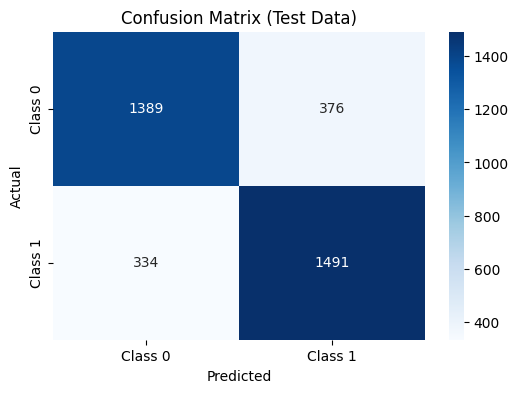

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.8094707520891364
Precision: 0.8016922263352724
Recall: 0.8306849315068493
F1 Score: 0.8159311087190527

=== Training Metrics ===
Accuracy: 0.8831847311228754
Precision: 0.8664374504099445
Recall: 0.9076049314309461
F1 Score: 0.8865435356200527

X_train shape: (14356, 23)


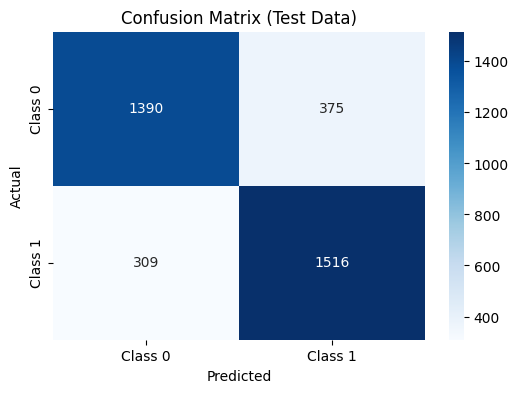

In [25]:
# Use random forest model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.8855153203342618
Precision: 0.8958566629339306
Recall: 0.8767123287671232
F1 Score: 0.8861811132650236

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


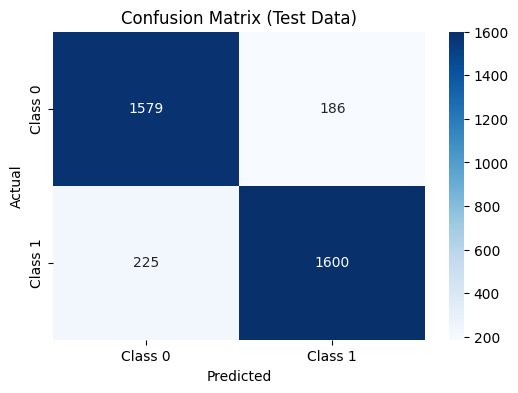

In [26]:
# Use random forest model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Methods

In [27]:
baseline_f1 = f1_score(y_test, clf.predict(X_test))
print(f"Baseline F1: {baseline_f1:.4f}")

# 2. Grab your feature names so we can report them
feature_names = df.drop(columns=['winner']).columns.tolist()

# 3. Prepare working copies of X and feature list
current_X_train = X_train.copy()
current_X_test  = X_test.copy()
features = feature_names.copy()
removed_features = []

# 4. Iteratively drop one feature at a time
while True:
    # build an RFE selector that will drop exactly one feature
    selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
    selector.fit(current_X_train, y_train)

    # evaluate F1 after dropping that one feature
    new_f1 = f1_score(y_test, selector.predict(current_X_test))
    # find which feature was dropped
    dropped_idx  = np.where(~selector.support_)[0][0]
    dropped_feat = features[dropped_idx]

    # if performance falls off, record and stop
    if new_f1 < baseline_f1:
        removed_features.append(dropped_feat)
        print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
        break

    # otherwise, record removal and continue
    removed_features.append(dropped_feat)
    print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

    # update feature list and training/testing matrices
    features.pop(dropped_idx)
    current_X_train = current_X_train[:, selector.support_]
    current_X_test  = current_X_test[:, selector.support_]

# 5. Summary of all dropped features
print(f"\nTotal removed: {len(removed_features)} features")
print("Features removed (in order):")
for feat in removed_features:
    print(f" - {feat}")

Baseline F1: 0.8077
Removed 'p1_hand' → new F1 = 0.8196
Removed 'p2_hand' → new F1 = 0.8172
Removed 'surface' → new F1 = 0.8179
Removed 'p1_ht' → new F1 = 0.8179
Removed 'p2_ht' → new F1 = 0.8203
Removed 'p1_age' → new F1 = 0.8197
Removed 'p2_age' → new F1 = 0.8241
Removed 'p1_df' → new F1 = 0.8166
Removed 'p2_df' → new F1 = 0.8165
Removed 'p1_1stIn' → new F1 = 0.8130
Removed 'p2_1stIn' → new F1 = 0.8101
Removed 'p1_ace' → new F1 = 0.8164
Removed 'p2_ace' → new F1 = 0.8269
Removed 'p2_rank' → new F1 = 0.8333
Removed 'p1_rank' → new F1 = 0.8499
Removed 'p1_2ndWon' → new F1 = 0.8215
Removed 'p1_svpt' → new F1 = 0.8106
Removed 'p2_rank_points' → new F1 = 0.8151
Removed 'p1_rank_points' → new F1 = 0.8290
→ Stopping: dropping 'p2_2ndWon' drops F1 from 0.8077 to 0.7506

Total removed: 20 features
Features removed (in order):
 - p1_hand
 - p2_hand
 - surface
 - p1_ht
 - p2_ht
 - p1_age
 - p2_age
 - p1_df
 - p2_df
 - p1_1stIn
 - p2_1stIn
 - p1_ace
 - p2_ace
 - p2_rank
 - p1_rank
 - p1_2ndWon
 

## KNN

=== Test Metrics ===
Accuracy: 0.7506963788300836
Precision: 0.745253164556962
Recall: 0.7742465753424658
F1 Score: 0.7594732598763774

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


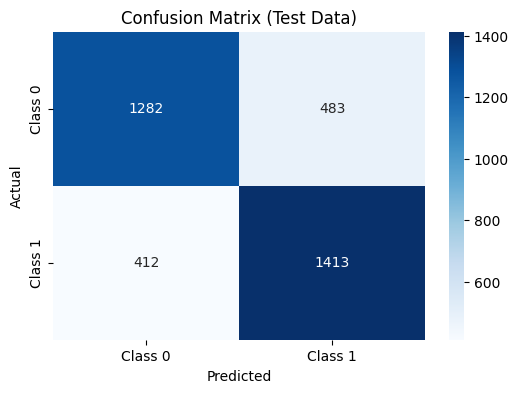

In [28]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and fit the model
neigh = KNeighborsClassifier(n_neighbors=100, weights='distance', algorithm='auto')
neigh.fit(X_train, y_train)

# Predictions
y_pred_test = neigh.predict(X_test)
y_pred_train = neigh.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.8094707520891364
Precision: 0.8016922263352724
Recall: 0.8306849315068493
F1 Score: 0.8159311087190527

=== Training Metrics ===
Accuracy: 0.8831847311228754
Precision: 0.8664374504099445
Recall: 0.9076049314309461
F1 Score: 0.8865435356200527

X_train shape: (14356, 23)


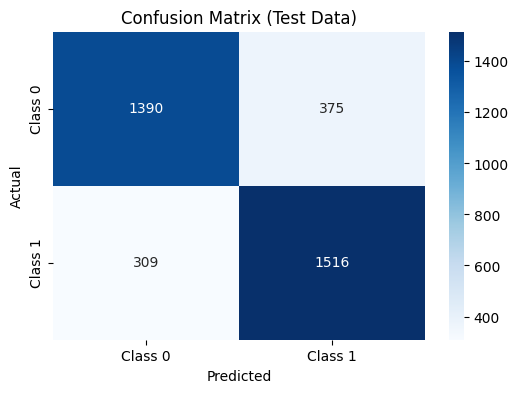

In [29]:
# Use KNN model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.8855153203342618
Precision: 0.8958566629339306
Recall: 0.8767123287671232
F1 Score: 0.8861811132650236

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


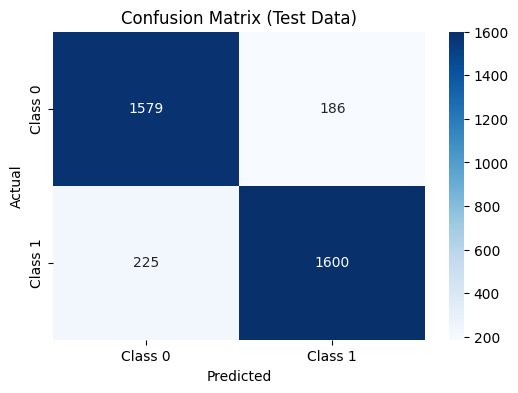

In [30]:
# Use KNN model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Method

In [31]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.8077
Removed 'p1_hand' → new F1 = 0.8196
Removed 'p2_hand' → new F1 = 0.8172
Removed 'surface' → new F1 = 0.8179
Removed 'p1_ht' → new F1 = 0.8179
Removed 'p2_ht' → new F1 = 0.8203
Removed 'p1_age' → new F1 = 0.8197
Removed 'p2_age' → new F1 = 0.8241
Removed 'p1_df' → new F1 = 0.8166
Removed 'p2_df' → new F1 = 0.8165
Removed 'p1_1stIn' → new F1 = 0.8130
Removed 'p2_1stIn' → new F1 = 0.8101
Removed 'p1_ace' → new F1 = 0.8164
Removed 'p2_ace' → new F1 = 0.8269
Removed 'p2_rank' → new F1 = 0.8333
Removed 'p1_rank' → new F1 = 0.8499
Removed 'p1_2ndWon' → new F1 = 0.8215
Removed 'p1_svpt' → new F1 = 0.8106
Removed 'p2_rank_points' → new F1 = 0.8151
Removed 'p1_rank_points' → new F1 = 0.8290
→ Stopping: dropping 'p2_2ndWon' drops F1 from 0.8077 to 0.7506

Total removed: 20 features
Features removed (in order):
 - p1_hand
 - p2_hand
 - surface
 - p1_ht
 - p2_ht
 - p1_age
 - p2_age
 - p1_df
 - p2_df
 - p1_1stIn
 - p2_1stIn
 - p1_ace
 - p2_ace
 - p2_rank
 - p1_rank
 - p1_2ndWon
 

## SVM Linear Kernel

=== Test Metrics ===
Accuracy: 0.9512534818941504
Precision: 0.9578246392896781
Recall: 0.9457534246575342
F1 Score: 0.9517507582023711

=== Training Metrics ===
Accuracy: 0.9474087489551407
Precision: 0.9454244762954797
Recall: 0.9502701205153068
F1 Score: 0.9478411053540587

X_train shape: (14356, 23)


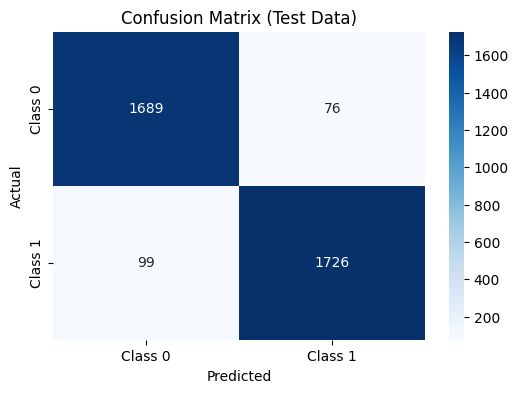

In [32]:
from sklearn.svm import LinearSVC

# Train the model
clf = LinearSVC(random_state=0, tol=1e-5, C=1.0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9515320334261839
Precision: 0.9578480310593456
Recall: 0.9463013698630137
F1 Score: 0.9520396912899669

=== Training Metrics ===
Accuracy: 0.9475480635274449
Precision: 0.9458080529509101
Recall: 0.9501315971741239
F1 Score: 0.9479648953078571

X_train shape: (14356, 23)


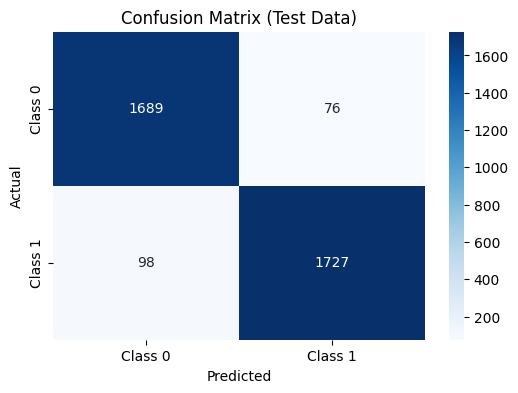

In [33]:
# Use linear SVM model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9387186629526463
Precision: 0.9382850901146914
Recall: 0.9413698630136986
F1 Score: 0.9398249452954048

=== Training Metrics ===
Accuracy: 0.9330593480078017
Precision: 0.930635838150289
Recall: 0.9366948330793738
F1 Score: 0.9336555056955471

X_train shape: (14356, 23)


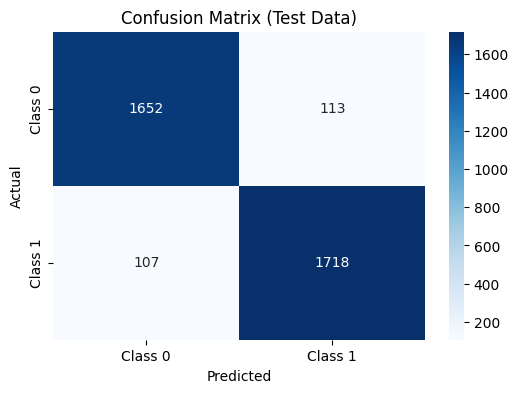

In [34]:
# Use linear SVM model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Method

In [35]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.9518
Removed 'p2_rank' → new F1 = 0.9518
Removed 'p2_rank_points' → new F1 = 0.9518
Removed 'p1_ht' → new F1 = 0.9518
Removed 'p2_df' → new F1 = 0.9518
Removed 'p2_ht' → new F1 = 0.9520
→ Stopping: dropping 'p1_hand' drops F1 from 0.9518 to 0.9515

Total removed: 6 features
Features removed (in order):
 - p2_rank
 - p2_rank_points
 - p1_ht
 - p2_df
 - p2_ht
 - p1_hand


## SVM Gaussian Kernel

=== Test Metrics ===
Accuracy: 0.935933147632312
Precision: 0.9437952142459655
Recall: 0.9293150684931507
F1 Score: 0.9364991717283269

=== Training Metrics ===
Accuracy: 0.9589022011702424
Precision: 0.9569833172480353
Recall: 0.9614905111511289
F1 Score: 0.9592316196793809

X_train shape: (14356, 23)


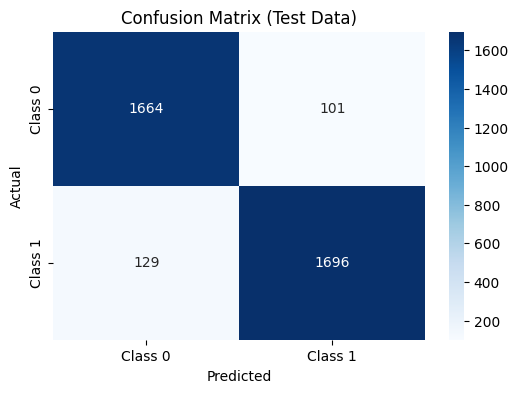

In [36]:
from sklearn.svm import SVC

# Train the model
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
clf.fit(X_train, y_train)

# Make predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9398328690807799
Precision: 0.9471928849360756
Recall: 0.9336986301369863
F1 Score: 0.9403973509933775

=== Training Metrics ===
Accuracy: 0.9571607690164391
Precision: 0.9591212458286985
Recall: 0.9555340074802604
F1 Score: 0.9573242661855527

X_train shape: (14356, 23)


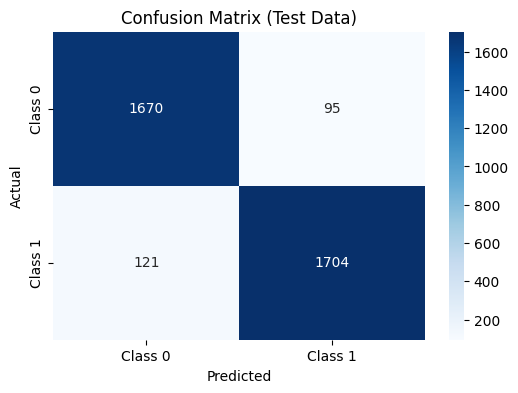

In [37]:
# Use gaussian SVM model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

# Note: Boosting results in the model predicting all 1s

## Stacking

### Decision Tree, KNN, & Random Forest -> Logistic

=== Test Metrics ===
Accuracy: 0.8233983286908078
Precision: 0.8284611141753999
Recall: 0.823013698630137
F1 Score: 0.8257284222100055

=== Training Metrics ===
Accuracy: 0.9993730844246308
Precision: 0.999031007751938
Recall: 0.999722953317634
F1 Score: 0.9993768607629994

X_train shape: (14356, 23)


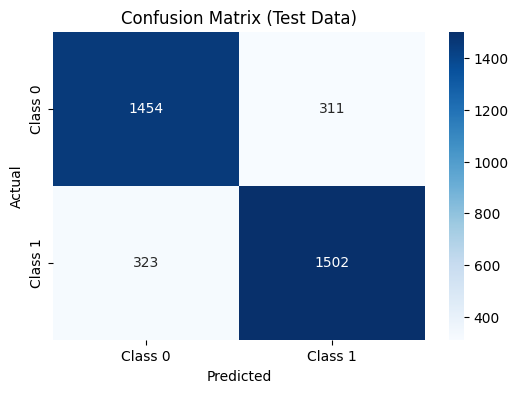

In [38]:
from sklearn.ensemble import StackingClassifier
estimators = [
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')],
  ["RandomForestClassifier", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Logistic & KNN -> Decision Tree

=== Test Metrics ===
Accuracy: 0.9323119777158775
Precision: 0.938470066518847
Recall: 0.9276712328767124
F1 Score: 0.9330394047947093

=== Training Metrics ===
Accuracy: 0.9111869601560323
Precision: 0.9196554645580345
Recall: 0.9022025211248095
F1 Score: 0.9108453954268932

X_train shape: (14356, 23)


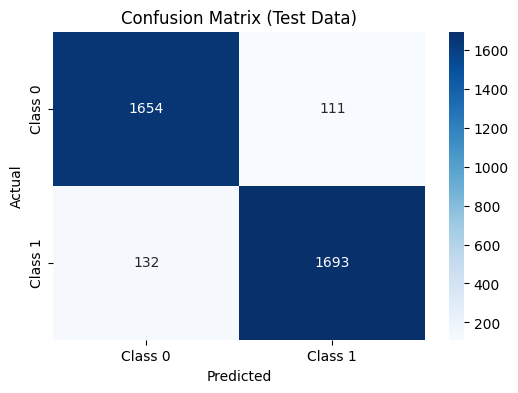

In [39]:
estimators = [
  ["LogisticRegression", LogisticRegression(random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Gaussian SVC & Decision Tree -> Logistic

=== Test Metrics ===
Accuracy: 0.9367688022284123
Precision: 0.9433962264150944
Recall: 0.9315068493150684
F1 Score: 0.9374138406396471

=== Training Metrics ===
Accuracy: 0.9641961549178044
Precision: 0.9622225286088515
Recall: 0.9667543981160825
F1 Score: 0.9644831398562742

X_train shape: (14356, 23)


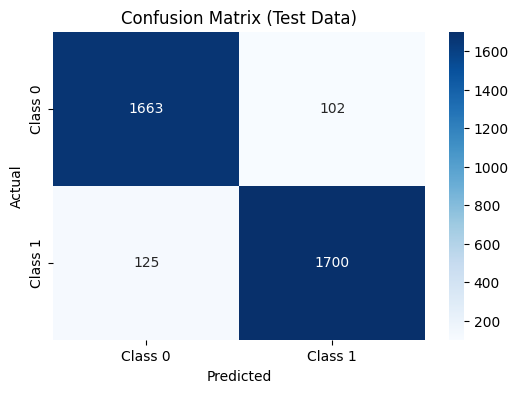

In [40]:
estimators = [
  ["SVC", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)],
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## KNN With HyperTuning

In [41]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV
# import pandas as pd

# param_grid = {
#     "n_neighbors": [100, 200],
#     "weights":     ["uniform", "distance"],
#     "metric":      ["euclidean", "manhattan"],
#     "algorithm":   ["auto", "kd_tree", "ball_tree"]
# }

# grid_knn = GridSearchCV(
#     estimator   = KNeighborsClassifier(),
#     param_grid  = param_grid,
#     scoring     = "balanced_accuracy",
#     verbose     = 0
# )

# grid_knn.fit(X_train, y_train)

# print("Best hyper‑parameters:", grid_knn.best_params_)
# print(f"Best score (train only): {grid_knn.best_score_:.4f}")

# best_knn      = grid_knn.best_estimator_
# y_pred_test   = best_knn.predict(X_test)
# y_pred_train  = best_knn.predict(X_train)

# # Custom evaluation
# evaluate_model(y_pred_test, y_pred_train)

# results = pd.DataFrame(grid_knn.cv_results_)
# top5 = results.sort_values(by="mean_test_score", ascending=False).head()

# print("Top 5 configs:")
# print(top5[["params", "mean_test_score"]])

## DecisionTreeClassifier with Hypertuning

In [42]:
# from sklearn.tree import DecisionTreeClassifier

# dt_manual = DecisionTreeClassifier(
#     criterion="entropy",
#     max_depth=10,
#     min_samples_split=10,
#     min_samples_leaf=5,
#     class_weight="balanced",
#     random_state=42
# )
# dt_manual.fit(X_train, y_train)

# y_pred_test  = dt_manual.predict(X_test)
# y_pred_train = dt_manual.predict(X_train)

# evaluate_model(y_pred_test, y_pred_train)

## Logistic Regression With Hypertuning

In [43]:
# # Tried on this one but not much change, running gridsearch on all will blow up our computers

# # testing elastic 
# from sklearn.linear_model import LogisticRegression

# log_manual = LogisticRegression(
#     penalty="elasticnet",
#     C=1.0,
#     l1_ratio=0.5,
#     class_weight="balanced",
#     solver="saga",
#     max_iter=10000,
#     random_state=42
# )
# log_manual.fit(X_train, y_train)

# y_pred_test  = log_manual.predict(X_test)
# y_pred_train = log_manual.predict(X_train)

# evaluate_model(y_pred_test, y_pred_train)